In [1]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import faiss
from torchvision import transforms
import time


/home/mohan.dash/Log_ReID/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Feature extractor

In [2]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = AutoModel.from_pretrained('facebook/dinov2-with-registers-small')

            # Provided normalization parameters
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]

        self.processor =  transforms.Compose([
                                        transforms.Resize((512, 512)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=self.image_mean, std=self.image_std)
                                    ])



        self.model.eval()
        

    @torch.no_grad()
    def forward(self, image):
        """
        Accepts a single PIL Image or a list of PIL Images.
        Returns CLS token features of shape (batch_size, hidden_dim).
        """
        if isinstance(image, Image.Image):
            # Single image
            inputs = self.processor(image).unsqueeze(0)  # (1, C, H, W)
        elif isinstance(image, list) and all(isinstance(img, Image.Image) for img in image):
            # List of images
            inputs = torch.stack([self.processor(img) for img in image])  # (B, C, H, W)
        else:
            raise ValueError("Input must be a single PIL Image or a list of PIL Images.")

        outputs = self.model(inputs.to(self.model.device))
        last_hidden_states = outputs.last_hidden_state
        # CLS token is the first token in the sequence
        cls_token = last_hidden_states[:, 0, :]  # shape: (batch_size, hidden_dim)
        return cls_token
    

    def denormalize(self,tensor):

        """
        Denormalizes a tensor image normalized with ImageNet statistics.

        Args:
            tensor (torch.Tensor): Tensor of shape (C, H, W) with normalized values.

        Returns:
            torch.Tensor: Denormalized tensor with pixel values in [0, 1] range.
        """
        mean = torch.tensor(self.image_mean).view(-1, 1, 1)
        std = torch.tensor(self.image_std).view(-1, 1, 1)
        denorm_tensor = tensor * std + mean
        return denorm_tensor.clamp(0, 1)  # Ensure values stay within [0, 1]

In [3]:
feature_extractor = FeatureExtractor()
feature_extractor = feature_extractor.to('cuda')

In [4]:
image = Image.open(Path(r"C:\Users\User\Downloads\test_dataset2\test_dataset\bride_blanc_08173_R2.jpg"))
inputs = feature_extractor(image)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\Downloads\\test_dataset2\\test_dataset\\bride_blanc_08173_R2.jpg'

# Test on the database Images

In [5]:
all_images = [p for p in Path(r"/home/mohan.dash/Log_ReID/test_dataset").iterdir() if p.parts[-1].endswith('_R1.jpg')]

database_images = all_images[:100]

nondatabase_test_images = all_images[100:]
database_test_images = [p.with_name(p.name.replace('_R1.jpg', '_R3.jpg')) for p in database_images]

print(len(database_images),len(nondatabase_test_images),len(database_test_images))


100 100 100


In [10]:
database_test_images[0]

WindowsPath('C:/Users/User/Downloads/test_dataset2/test_dataset/bride_blanc_08173_R3.jpg')

## Extract features beforehand

In [6]:
from tqdm.auto import tqdm

database_image_features = []

for idx, image_path in tqdm(enumerate(database_images), total=len(database_images)):
    image = Image.open(image_path)

    inputs = feature_extractor(image)
    database_image_features.append(inputs.squeeze(0).detach().cpu().numpy())

100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


In [7]:
# Convert to NumPy array
features_array = np.stack(database_image_features).astype('float32')  # shape: (num_images, hidden_dim)


In [8]:
# Create FAISS index
dim = features_array.shape[1]  # feature dimension
index = faiss.IndexFlatL2(dim)  # L2 distance (Euclidean)
index.add(features_array)  # add features to the index

In [9]:
print(f"FAISS index created with {index.ntotal} images.")

FAISS index created with 100 images.


In [10]:
faiss.write_index(index, r"C:\Users\User\Desktop\Log_ReID\databse_files\faiss_index.idx")
# index = faiss.read_index("faiss_index.idx")

# Query an image

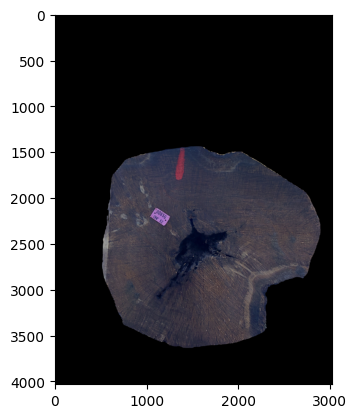

In [133]:
retrieved_image = Image.open(database_images[I.flatten()[1]]).convert("RGB")
plt.imshow(retrieved_image)

In [28]:
plt.imshow(feature_extractor.denormalize(img_tensor['pixel_values'][0]).permute(1, 2, 0).cpu().numpy())

NameError: name 'img_tensor' is not defined

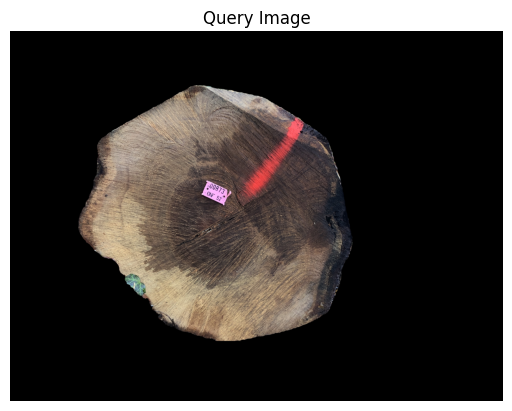

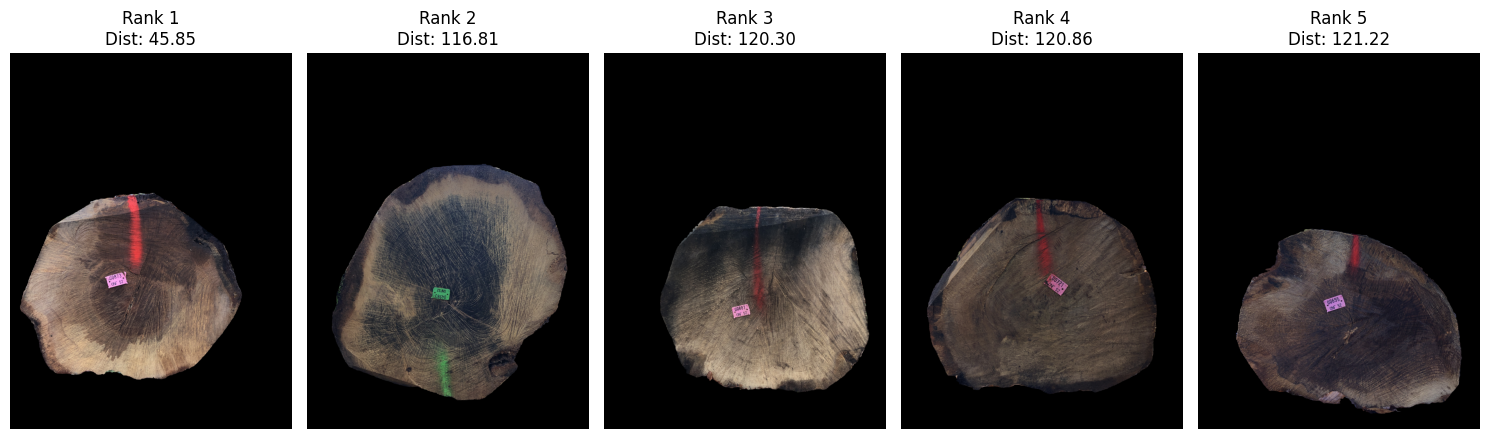

In [36]:


# Load query image
query_image = Image.open(database_test_images[54]).convert("RGB")

# Extract features
query_image_features = feature_extractor(query_image).detach().cpu().numpy()

D, I = index.search(query_image_features, k=5)



plt.imshow(query_image)
plt.title("Query Image")
plt.axis("off")
plt.show()

# Plot query image and top 5 retrieved images
plt.figure(figsize=(15, 5))

# Plot query image
plt.subplot(1, 5, 1)
# Plot retrieved images
for idx, img_idx in enumerate(I.flatten()):

    retrieved_image = Image.open(database_images[img_idx]).convert("RGB")
    
    plt.subplot(1, 5, idx + 1)
    plt.imshow(retrieved_image)
    plt.title(f"Rank {idx + 1}\nDist: {D[0, idx]:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Evaluation Metric

In [30]:
# Create ground truth labels
ground_truth = [0] * len(nondatabase_test_images) + [1] * len(database_test_images)


In [31]:
query_images = [Image.open(img_pth).convert("RGB") for img_pth in database_test_images]

# Extract features
query_image_features = feature_extractor(query_images).detach().cpu().numpy()

D, I = index.search(query_image_features, k=5)

In [32]:
for idx, ss in enumerate(I):
    if ss[0]!=idx:
        print(ss,idx)